In [1]:
import joblib
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


In [4]:
!pip install lightgbm

In [5]:
!pip install xgboost

In [7]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

Keşifçi Veri Analizi ( EDA )

In [12]:
def load():
  df = pd.read_csv("/content/diabetes.csv")
  return df

df = load()

In [ ]:
#Veri Setine Ön Bakış

In [9]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
#Kategorik ve Numerik Değişken Analizi

In [10]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

In [13]:
def num_summary(dataframe, numerical_col, plot=False):
  quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[numerical_col].describe(quantiles).T)
  if plot:
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.title(numerical_col)
    plt.show(block=True)

In [ ]:
#Bağımlı Değişken Analizi

In [14]:
def target_summary_with_num(dataframe, target, numerical_col):
  print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
  print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

In [ ]:
#Korelasyon Matrisi

In [15]:
def corr_matrix(df, cols):
  fig = plt.gcf()
  fig.set_size_inches(10, 8)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size':12}, linecolor='w', cmap='RdBu')
  plt.show(block=True)

In [ ]:
#Kategorik ve Numerik Sütunlar

In [16]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
  num_cols = [col for col in num_cols if col not in num_but_cat]

  print(f"Observations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f'cat_cols: {len(cat_cols)}')
  print(f'num_cols: {len(num_cols)}')
  print(f'cat_but_car: {len(cat_but_car)}')
  print(f'num_but_cat: {len(num_but_cat)}')
  return cat_cols, num_cols, cat_but_car

In [17]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0  33.6                     0.627   50        1
1            1       85             66             29        0  26.6                     0.351   31        0
2            8      183             64              0        0  23.3                     0.672   32        1
3            1       89             66             23       94  28.1

In [18]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
cat_cols, num_cols

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


(['Outcome'],
 ['Pregnancies',
  'Glucose',
  'BloodPressure',
  'SkinThickness',
  'Insulin',
  'BMI',
  'DiabetesPedigreeFunction',
  'Age'])

In [19]:
for col in cat_cols:
  cat_summary(df, col)

         Outcome      Ratio
Outcome                    
0            500  65.104167
1            268  34.895833
##########################################


In [20]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64


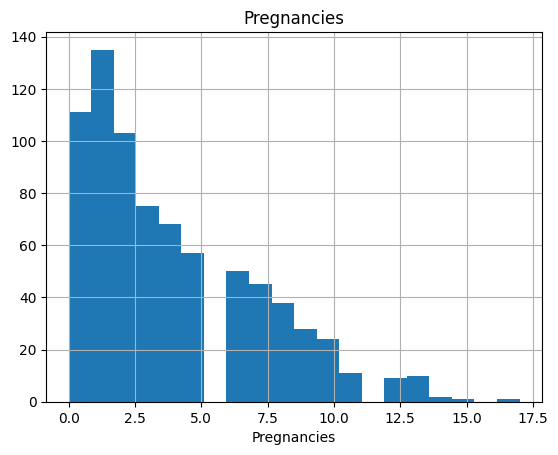

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64


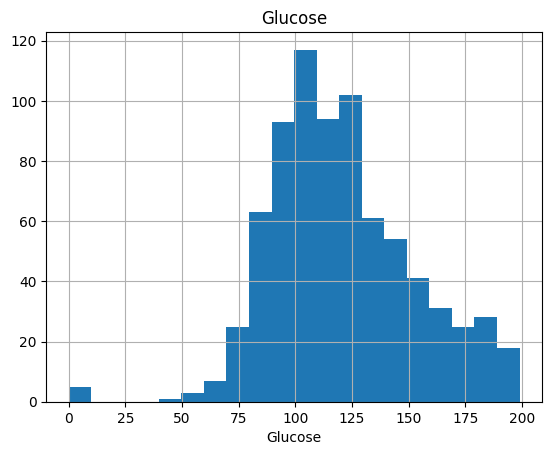

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
20%       60.000000
30%       64.000000
40%       68.000000
50%       72.000000
60%       74.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BloodPressure, dtype: float64


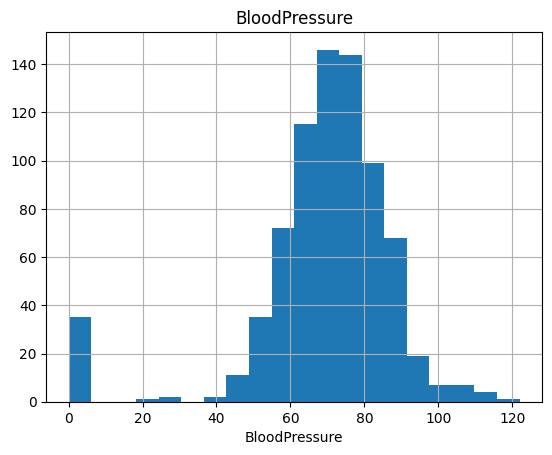

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        8.200000
40%       18.000000
50%       23.000000
60%       27.000000
70%       31.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: SkinThickness, dtype: float64


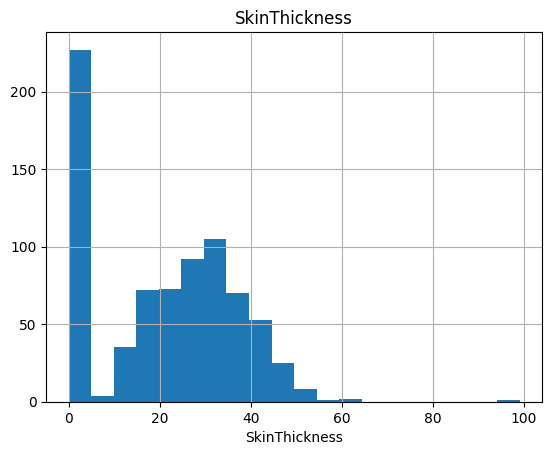

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
70%      106.000000
80%      150.000000
90%      210.000000
95%      293.000000
99%      519.900000
max      846.000000
Name: Insulin, dtype: float64


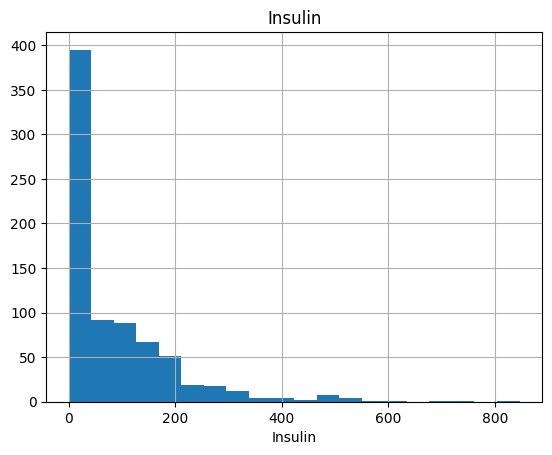

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
20%       25.900000
30%       28.200000
40%       30.100000
50%       32.000000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


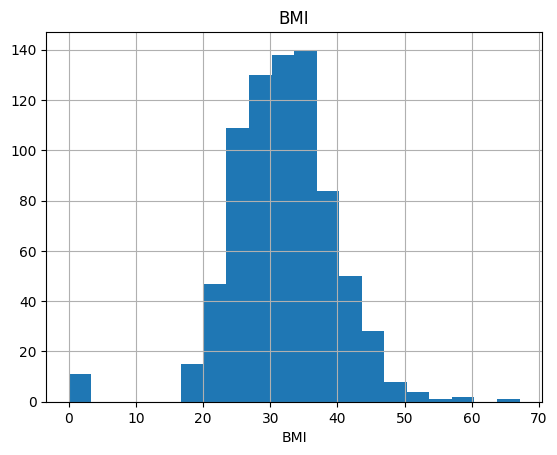

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64


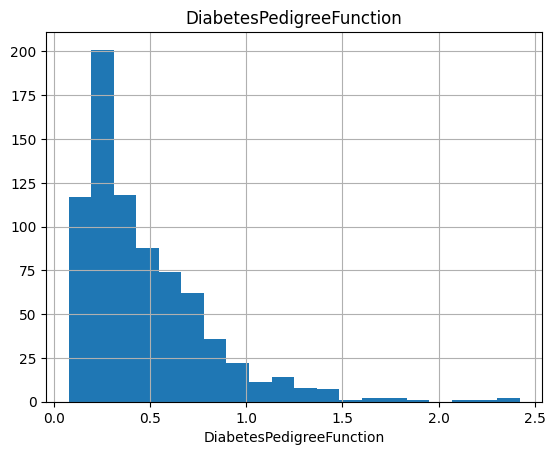

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: Age, dtype: float64


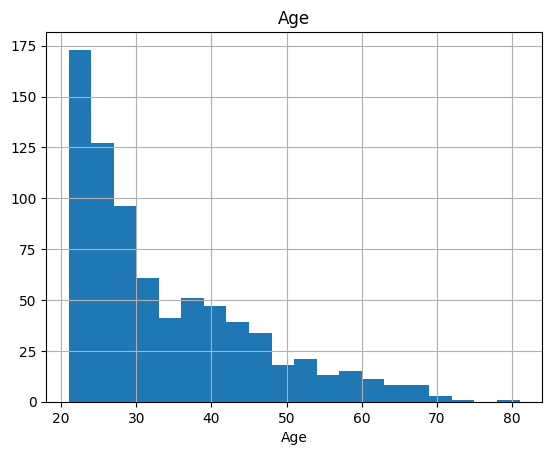

In [21]:
for col in num_cols:
  num_summary(df, col, plot=True)

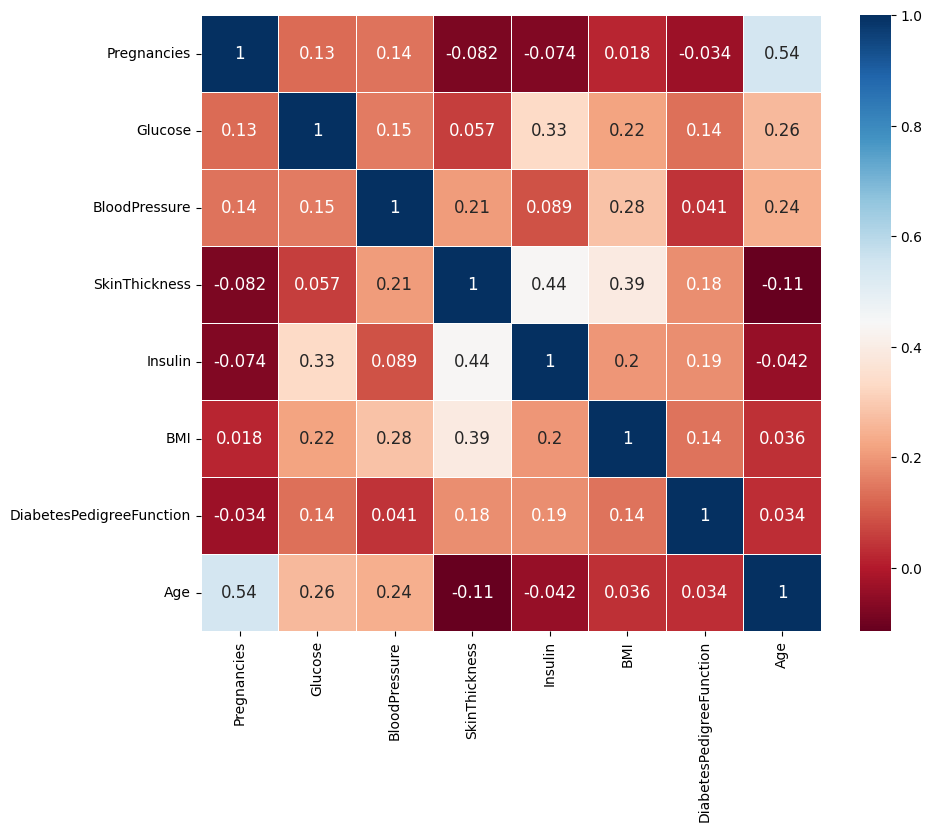

In [22]:
corr_matrix(df, num_cols)

In [23]:
for col in num_cols:
  target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            68.184000
1            70.824627


         SkinThickness
Outcome               
0            19.664000
1            22.164179


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164




Veri Ön İşleme

In [ ]:
#Aykırı Değerler

In [24]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

In [25]:
def replace_with_thresholds(dataframe, variable):
  low_limit, up_limit = outlier_thresholds(dataframe, variable)
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
  dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [26]:
def check_outlier(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

In [ ]:
#Encoding

In [27]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True, dtype="int"):
  dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dtype=dtype)
  return dataframe

In [28]:
# değişken isimlerini büyütelim
df.columns = [col.upper() for col in df.columns]

In [ ]:
#Yeni Değişkenler

In [29]:
# glucose
df['NEW_GLUCOSE_CAT'] = pd.cut(df['GLUCOSE'], bins=[-1, 139, 200], labels=["NORMAL", "PRE-DIABETIC"])

# age
df.loc[(df['AGE'] < 35), "NEW_AGE_CAT"] = 'YOUNG'
df.loc[(df['AGE'] >= 35) & (df['AGE'] <= 55), "NEW_AGE_CAT"] = 'MIDDLE'
df.loc[(df['AGE'] > 55), "NEW_AGE_CAT"] = 'OLD'

# bmi
df['NEW_BMI_RANGE'] = pd.cut(x=df['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100], labels=['UNDERWEIGHT', 'HEALTHY', 'OVERWEIGHT', 'OBESE'])

# bloodpressure
df['NEW_BLOODPRESSURE'] = pd.cut(x=df['BLOODPRESSURE'], bins=[-1, 79, 89, 123], labels=['NORMAL', 'HS1', 'HS2'])


In [30]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
cat_cols, num_cols, cat_but_car

Observations: 768
Variables: 13
cat_cols: 5
num_cols: 8
cat_but_car: 0
num_but_cat: 4


(['NEW_AGE_CAT',
  'OUTCOME',
  'NEW_GLUCOSE_CAT',
  'NEW_BMI_RANGE',
  'NEW_BLOODPRESSURE'],
 ['PREGNANCIES',
  'GLUCOSE',
  'BLOODPRESSURE',
  'SKINTHICKNESS',
  'INSULIN',
  'BMI',
  'DIABETESPEDIGREEFUNCTION',
  'AGE'],
 [])

In [31]:
for col in cat_cols:
  cat_summary(df, col)

             NEW_AGE_CAT      Ratio
NEW_AGE_CAT                        
YOUNG                488  63.541667
MIDDLE               230  29.947917
OLD                   50   6.510417
##########################################
         OUTCOME      Ratio
OUTCOME                    
0            500  65.104167
1            268  34.895833
##########################################
                 NEW_GLUCOSE_CAT      Ratio
NEW_GLUCOSE_CAT                            
NORMAL                       571  74.348958
PRE-DIABETIC                 197  25.651042
##########################################
               NEW_BMI_RANGE      Ratio
NEW_BMI_RANGE                          
OBESE                    472  61.458333
OVERWEIGHT               179  23.307292
HEALTHY                  102  13.281250
UNDERWEIGHT               15   1.953125
##########################################
                   NEW_BLOODPRESSURE      Ratio
NEW_BLOODPRESSURE                              
NORMAL                  

In [32]:
for col in cat_cols:
  target_summary_with_cat(df, "OUTCOME", col)

             TARGET_MEAN
NEW_AGE_CAT             
MIDDLE          0.543478
OLD             0.340000
YOUNG           0.258197


         TARGET_MEAN
OUTCOME             
0                0.0
1                1.0


                 TARGET_MEAN
NEW_GLUCOSE_CAT             
NORMAL              0.232925
PRE-DIABETIC        0.685279


               TARGET_MEAN
NEW_BMI_RANGE             
UNDERWEIGHT       0.133333
HEALTHY           0.068627
OVERWEIGHT        0.223464
OBESE             0.463983


                   TARGET_MEAN
NEW_BLOODPRESSURE             
NORMAL                0.316163
HS1                   0.420690
HS2                   0.483333




<ipython-input-14-4f998769d81d>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")
<ipython-input-14-4f998769d81d>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")
<ipython-input-14-4f998769d81d>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and s

In [33]:
cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

In [34]:
df = one_hot_encoder(df, cat_cols)

In [35]:
df.columns = [col.upper() for col in df.columns]

In [36]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

Observations: 768
Variables: 17
cat_cols: 9
num_cols: 8
cat_but_car: 0
num_but_cat: 9


In [37]:
for col in num_cols:
  print(col, check_outlier(df, col))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN True
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


In [38]:
replace_with_thresholds(df, "INSULIN")

<ipython-input-25-6a2133861800>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-439.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


In [ ]:
#Standartlaştırma

In [39]:
x_scaled = StandardScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(x_scaled, columns=df[num_cols].columns)

In [40]:
y = df["OUTCOME"]
x = df.drop(["OUTCOME"], axis=1)
check_df(x)

##################### Shape #####################
(768, 16)
##################### Types #####################
PREGNANCIES                     float64
GLUCOSE                         float64
BLOODPRESSURE                   float64
SKINTHICKNESS                   float64
INSULIN                         float64
BMI                             float64
DIABETESPEDIGREEFUNCTION        float64
AGE                             float64
NEW_AGE_CAT_OLD                   int64
NEW_AGE_CAT_YOUNG                 int64
NEW_GLUCOSE_CAT_PRE-DIABETIC      int64
NEW_BMI_RANGE_HEALTHY             int64
NEW_BMI_RANGE_OVERWEIGHT          int64
NEW_BMI_RANGE_OBESE               int64
NEW_BLOODPRESSURE_HS1             int64
NEW_BLOODPRESSURE_HS2             int64
dtype: object
##################### Head #####################
   PREGNANCIES   GLUCOSE  BLOODPRESSURE  SKINTHICKNESS   INSULIN       BMI  DIABETESPEDIGREEFUNCTION       AGE  NEW_AGE_CAT_OLD  NEW_AGE_CAT_YOUNG  NEW_GLUCOSE_CAT_PRE-DIABETIC  NEW_BMI_R

In [41]:
df = load()

In [42]:
def diabetes_data_prep(df):
  df.columns = [col.upper() for col in df.columns]

  # glucose
  df['NEW_GLUCOSE_CAT'] = pd.cut(df['GLUCOSE'], bins=[-1, 139, 200], labels=["NORMAL", "PRE-DIABETIC"])

  # age
  df.loc[(df['AGE'] < 35), "NEW_AGE_CAT"] = 'YOUNG'
  df.loc[(df['AGE'] >= 35) & (df['AGE'] <= 55), "NEW_AGE_CAT"] = 'MIDDLE'
  df.loc[(df['AGE'] > 55), "NEW_AGE_CAT"] = 'OLD'

  # bmi
  df['NEW_BMI_RANGE'] = pd.cut(x=df['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100], labels=['UNDERWEIGHT', 'HEALTHY', 'OVERWEIGHT', 'OBESE'])

  # bloodpressure
  df['NEW_BLOODPRESSURE'] = pd.cut(x=df['BLOODPRESSURE'], bins=[-1, 79, 89, 123], labels=['NORMAL', 'HS1', 'HS2'])

  cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
  cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

  df = one_hot_encoder(df, cat_cols, drop_first=True)

  cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
  cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

  replace_with_thresholds(df, "INSULIN")

  x_scaled = StandardScaler().fit_transform(df[num_cols])
  df[num_cols] = pd.DataFrame(x_scaled, columns=df[num_cols].columns)

  y = df["OUTCOME"]
  x = df.drop(["OUTCOME"], axis=1)

  return x, y

In [43]:
x, y = diabetes_data_prep(df)

Observations: 768
Variables: 13
cat_cols: 5
num_cols: 8
cat_but_car: 0
num_but_cat: 4
Observations: 768
Variables: 17
cat_cols: 9
num_cols: 8
cat_but_car: 0
num_but_cat: 9


<ipython-input-25-6a2133861800>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-439.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


model


In [44]:
def base_models(x, y, scoring="roc_auc"):
  print("BASE MODELS....")
  classifiers = [('LR', LogisticRegression()),
                 ('KNN', KNeighborsClassifier()),
                 ("SVC", SVC()),
                 ("CART", DecisionTreeClassifier()),
                 ("RF", RandomForestClassifier()),
                 ("Adaboost", AdaBoostClassifier()),
                 ("GBM", GradientBoostingClassifier()),
                 #("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                 ("LightGBM", LGBMClassifier(verbose=-1)),
                 ("CatBoost", CatBoostClassifier(verbose=False))
                 ]


  for name, classifier in classifiers:
    cv_results = cross_validate(classifier, x, y, cv=3, scoring=scoring)
    print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

In [45]:
import warnings
warnings.filterwarnings("ignore")

In [46]:
base_models(x, y)

BASE MODELS....
roc_auc: 0.841 (LR) 
roc_auc: 0.7808 (KNN) 
roc_auc: 0.8354 (SVC) 
roc_auc: 0.6622 (CART) 
roc_auc: 0.8306 (RF) 
roc_auc: 0.8181 (Adaboost) 
roc_auc: 0.8251 (GBM) 
roc_auc: 0.8015 (LightGBM) 
roc_auc: 0.836 (CatBoost) 


Otomatik Hiperparametre Optimizasyonu

In [47]:
knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15,None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                 "max_depth": [5, 8],
                 "n_estimators": [100, 200],
                 "colsample_bytree": [0.5, 1]}

lightgbm_params = {"learning_rate": [0.1, 0.01],
                 "n_estimators": [300, 500],
                 "colsample_bytree": [0.7, 1]}

In [48]:
classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ('CART', DecisionTreeClassifier(), cart_params),
               ('RF', RandomForestClassifier(), rf_params),
               #('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric="logloss"), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]


In [49]:
def  hyperparameter_optimization(x, y, cv=3, scoring="roc_auc"):
  print("HYPERPARAMETER OPTIMIZATION....")
  best_models = {}
  for name, classifier, params in classifiers:
    print(f"########## {name} ##########")
    cv_results = cross_validate(classifier, x, y, cv=cv, scoring=scoring)
    print(f"{scoring} (BEFORE): {round(cv_results['test_score'].mean(), 4)}")

    gs_best_params = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(x, y)
    final_model = classifier.set_params(**gs_best_params.best_params_)

    cv_results = cross_validate(final_model, x, y, cv=cv, scoring=scoring)
    print(f"{scoring} (AFTER): {round(cv_results['test_score'].mean(), 4)}")
    print(f"{name} best params: {gs_best_params.best_params_}", end="\n\n")
    best_models[name] = final_model

  return best_models

In [50]:
best_models = hyperparameter_optimization(x, y)

HYPERPARAMETER OPTIMIZATION....
########## KNN ##########
roc_auc (BEFORE): 0.7808
roc_auc (AFTER): 0.8148
KNN best params: {'n_neighbors': 16}

########## CART ##########
roc_auc (BEFORE): 0.6569
roc_auc (AFTER): 0.7992
CART best params: {'max_depth': 6, 'min_samples_split': 25}

########## RF ##########
roc_auc (BEFORE): 0.8246
roc_auc (AFTER): 0.8321
RF best params: {'max_depth': 8, 'max_features': 7, 'min_samples_split': 15, 'n_estimators': 200}

########## LightGBM ##########
roc_auc (BEFORE): 0.8015
roc_auc (AFTER): 0.8221
LightGBM best params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 300}



Stacking & Ensemble Learning

In [ ]:
# birden fazla algoritmanın tahminleri

In [ ]:
# ornegin en başarılı 3 modelin ortak sonuçları

In [51]:
def voting_classifier(best_models, x, y):
  print("VOTING CLASSIFIER....")
  voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]),
                                          ('LightGBM', best_models["LightGBM"]),
                                          ('RF', best_models["RF"])],
                                            voting='soft').fit(x, y)
  cv_results = cross_validate(voting_clf, x, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
  print(f"accuracy: {cv_results['test_accuracy'].mean()}")
  print(f"f1: {cv_results['test_f1'].mean()}")
  print(f"roc_auc: {cv_results['test_roc_auc'].mean()}")
  return voting_clf

In [52]:
voting_clf = voting_classifier(best_models, x, y)

VOTING CLASSIFIER....
accuracy: 0.7669270833333334
f1: 0.6268428548755779
roc_auc: 0.8349347452230896


In [ ]:
#Tahminleme

In [53]:
x.columns

Index(['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE', 'NEW_AGE_CAT_OLD', 'NEW_AGE_CAT_YOUNG', 'NEW_GLUCOSE_CAT_PRE-DIABETIC', 'NEW_BMI_RANGE_HEALTHY', 'NEW_BMI_RANGE_OVERWEIGHT', 'NEW_BMI_RANGE_OBESE', 'NEW_BLOODPRESSURE_HS1', 'NEW_BLOODPRESSURE_HS2'], dtype='object')

In [54]:
joblib.dump(voting_clf, "voting_clf.pkl")

['voting_clf.pkl']

In [55]:
new_model = joblib.load("voting_clf.pkl")

In [56]:
random_user = x.sample(1, random_state=45)
new_model.predict(random_user)

array([1])

Pipeline Main Function

In [57]:
def main():
  df = pd.read_csv("diabetes.csv")
  x, y = diabetes_data_prep(df)
  base_models(x, y)
  best_models = hyperparameter_optimization(x, y)
  voting_clf = voting_classifier(best_models, x, y)
  joblib.dump(voting_clf, "voting_clf.pkl")
  return voting_clf

In [58]:
if __name__ == "__main__":
  main()

Observations: 768
Variables: 13
cat_cols: 5
num_cols: 8
cat_but_car: 0
num_but_cat: 4
Observations: 768
Variables: 17
cat_cols: 9
num_cols: 8
cat_but_car: 0
num_but_cat: 9
BASE MODELS....
roc_auc: 0.841 (LR) 
roc_auc: 0.7808 (KNN) 
roc_auc: 0.8354 (SVC) 
roc_auc: 0.6572 (CART) 
roc_auc: 0.8265 (RF) 
roc_auc: 0.8181 (Adaboost) 
roc_auc: 0.825 (GBM) 
roc_auc: 0.8015 (LightGBM) 
roc_auc: 0.836 (CatBoost) 
HYPERPARAMETER OPTIMIZATION....
########## KNN ##########
roc_auc (BEFORE): 0.8148
roc_auc (AFTER): 0.8148
KNN best params: {'n_neighbors': 16}

########## CART ##########
roc_auc (BEFORE): 0.7992
roc_auc (AFTER): 0.7714
CART best params: {'max_depth': 4, 'min_samples_split': 18}

########## RF ##########
roc_auc (BEFORE): 0.8344
roc_auc (AFTER): 0.8379
RF best params: {'max_depth': 15, 'max_features': 5, 'min_samples_split': 20, 'n_estimators': 200}

########## LightGBM ##########
roc_auc (BEFORE): 0.8221
roc_auc (AFTER): 0.8221
LightGBM best params: {'colsample_bytree': 0.7, 'learning_

Prediction

In [59]:
df = load()

In [63]:
random_user = df.sample(1, random_state=45)
new_model = joblib.load("voting_clf.pkl")
new_model.predict(random_user)
# eski ve yeni değişkenlerin boyut hatası var

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Age
- BloodPressure
- DiabetesPedigreeFunction
- Glucose
- Insulin
- ...
Feature names seen at fit time, yet now missing:
- AGE
- BLOODPRESSURE
- DIABETESPEDIGREEFUNCTION
- GLUCOSE
- INSULIN
- ...


In [64]:
x, y = diabetes_data_prep(df)

Observations: 768
Variables: 13
cat_cols: 5
num_cols: 8
cat_but_car: 0
num_but_cat: 4
Observations: 768
Variables: 17
cat_cols: 9
num_cols: 8
cat_but_car: 0
num_but_cat: 9


In [65]:
random_user = x.sample(1, random_state=45)
new_model = joblib.load("voting_clf.pkl")
new_model.predict(random_user)

array([1])